In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 901kB 20.1MB/s 
     |████████████████████████████████| 3.3MB 27.8MB/s 


In [ ]:
import json
import re
from tqdm.notebook import tqdm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict, OrderedDict
import glob
import sys
from keras import backend as K

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy import spatial
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from tqdm import tqdm
from transformers import (
    BertModel, BertConfig, BertTokenizer, TrainingArguments, 
    Trainer, LineByLineTextDataset, DataCollatorForLanguageModeling,
    DataCollatorWithPadding, DataCollator, BertForMaskedLM, BertForPreTraining
)

ModuleNotFoundError: ignored

In [ ]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-12_H-128_A-2')
config = BertConfig.from_pretrained('google/bert_uncased_L-12_H-128_A-2', output_hidden_states=True)
model = BertModel.from_pretrained('google/bert_uncased_L-12_H-128_A-2', config=config)

Some weights of the model checkpoint at google/bert_uncased_L-12_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_embeddings_from_last(text, tokenizer=tokenizer, model=model):
    """Вытягивает векторные представления для слов в тексте как крайние hidden states"""
    encoded_input = tokenizer(text, return_tensors='pt')
    word_embeddings = model(**encoded_input)[2][-1][0].detach().numpy()[1:-1]
    return word_embeddings

def get_embeddings(text, tokenizer=tokenizer, model=model):
    """Вытягивает векторные представления для слов в тексте на основе 4 крайних hidden states"""
    encoded_input = tokenizer(text, return_tensors='pt')
    four_last_hidden = model(**encoded_input)[2][-4:]
    four_last_hidden = np.asarray([hidden[0].detach().numpy() for hidden in four_last_hidden])
    word_embeddings = four_last_hidden[:, 1:-1].sum(axis=0)
    return word_embeddings

In [ ]:
with open('drive/MyDrive/Coursework2021/sticked_file.txt', 'r') as f:
    sentences = f.read().split('\n')
sentences[2]

'then HE go down to the front door for the damp twisted roll of the DATE TIME be paper and come back and ring the breakfast bell for the FIRST time'

In [ ]:
# определяем частотность токенов для сэмплирования
token_cnt = Counter()
for sentence in tqdm(sentences):
    token_cnt += Counter(tokenizer.tokenize(sentence))

100%|██████████| 128003/128003 [02:25<00:00, 877.71it/s]


In [ ]:
token_cnt.most_common(10)

[('he', 242536),
 ('the', 107735),
 ('be', 83369),
 ('and', 61358),
 ('of', 55266),
 ('to', 48600),
 ('a', 44717),
 ('in', 31885),
 ('have', 29213),
 ('that', 25309)]

In [ ]:
bert_embeddings = np.load('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab_embeddings.npy')
with open('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab.txt', 'r') as f:
    bert_vocab = f.read().split('\n')[:-1]
token2embed = dict(zip(bert_vocab, bert_embeddings))
print(bert_embeddings.shape)
print(bert_vocab[:5])

(30522, 128)
['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]']


In [ ]:
sample_weight = np.asarray([token_cnt[token] for token in bert_vocab]) / sum(token_cnt.values())
# sample_weight = np.maximum(0.005, sample_weight)  # каждое слово не больше threshold

In [ ]:
sample_weight.sum()

1.0

In [ ]:
sorted(sample_weight)[-10:]

[0.012284145303252248,
 0.014179016821838395,
 0.015475916590706781,
 0.02170414182802682,
 0.023588820646333684,
 0.026824274934985133,
 0.02978112874933626,
 0.04046453474206158,
 0.052290979266106166,
 0.11771889309216434]

In [ ]:
np.sum(sorted(sample_weight)[::-1][:int(0.01 * 30522)]) / sample_weight.sum()

0.012060053225155949

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import InputLayer, Dense
from keras.models import Model, Sequential

ORIGINAL_DIM = 128
TARGET_DIM = 16

encoder = Sequential([
    InputLayer(input_shape=(ORIGINAL_DIM,)),
    # Dense(60, activation='LeakyReLU'),
    Dense(TARGET_DIM, activation='LeakyReLU')
])

decoder = Sequential([
    InputLayer(input_shape=(TARGET_DIM,)),
    # Dense(60, activation='LeakyReLU'),
    Dense(ORIGINAL_DIM, activation=None)
])

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def root_mean_squared_error_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
autoencoder.fit(bert_embeddings, bert_embeddings, batch_size=32, epochs=18, sample_weight=sample_weight * bert_embeddings.shape[0])

Epoch 1/18
954/954 [==============================] - 1s 1ms/step - loss: 3.4543
Epoch 2/18
954/954 [==============================] - 1s 1ms/step - loss: 3.3324
Epoch 3/18
954/954 [==============================] - 1s 1ms/step - loss: 2.6748
Epoch 4/18
954/954 [==============================] - 1s 1ms/step - loss: 2.4082
Epoch 5/18
954/954 [==============================] - 1s 1ms/step - loss: 2.5739
Epoch 6/18
954/954 [==============================] - 1s 1ms/step - loss: 2.6693
Epoch 7/18
954/954 [==============================] - 1s 1ms/step - loss: 2.4745
Epoch 8/18
954/954 [==============================] - 1s 1ms/step - loss: 2.3477
Epoch 9/18
954/954 [==============================] - 1s 1ms/step - loss: 2.2403
Epoch 10/18
954/954 [==============================] - 1s 1ms/step - loss: 2.2765
Epoch 11/18
954/954 [==============================] - 1s 1ms/step - loss: 2.3640
Epoch 12/18
954/954 [==============================] - 1s 1ms/step - loss: 2.2847
Epoch 13/18
933/954 [====

KeyboardInterrupt: ignored

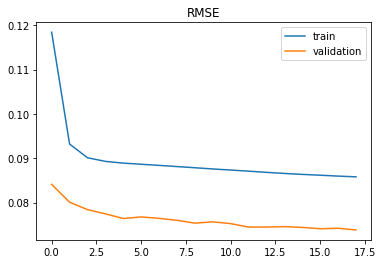

In [ ]:
plt.plot(np.sqrt(autoencoder.history.history['loss']), label='train')
plt.plot(np.sqrt(autoencoder.history.history['val_loss']), label='validation')
plt.legend()
plt.title('RMSE')
plt.show()

In [ ]:
np.sum(sample_weight * rmse(bert_embeddings, autoencoder(bert_embeddings).numpy()))

1.3018626

In [ ]:
from sklearn.metrics import mean_squared_error as mse

snp.sqrt(sample_weight * mse(bert_embeddings, autoencoder(bert_embeddings)))

array([0., 0., 0., ..., 0., 0., 0.])

## Класс Автоенкодер + резы

In [ ]:
import numpy as np
import sys
from keras.callbacks import History
from keras.layers import InputLayer, Dense
from keras.models import Model, Sequential
from sklearn.metrics import mean_squared_error as mse
from typing import List, Optional, Sequence


class Autoencoder(Model):
    """
    Холдер для одного автоенкодера
    """
    def __init__(self, input_dim: int, output_dim: int, activation: Optional[str] = None) -> None:
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.build_autoencoder()

    def call(self, inputs):
        return self.autoencoder(inputs)

    def build_autoencoder(self) -> None:
        self.encoder = Sequential([
            InputLayer(input_shape=(self.input_dim,)),
            # Dense(90, activation='tanh'),
            # Dense(32, activation='relu'),
            Dense(self.output_dim, activation=self.activation)
        ])
        self.decoder = Sequential([
            InputLayer(input_shape=(self.output_dim,)),
            # Dense(32, activation='relu'),
            # Dense(90, activation='tanh'),
            Dense(self.input_dim, activation=None)
        ])
        self.autoencoder = Model(inputs=self.encoder.input, outputs=self.decoder(self.encoder.output))
        self.autoencoder.compile(loss='mse', optimizer='adam')


class StackedAutoencoder:
    """
    Ступенчатый автоенкодер: отдельно обучается каждый слой-encoder на основе результатов предыдущего слоя
    """
    def __init__(self, dims: Sequence[int], activation: Optional[str] = 'tanh') -> None:
        """:param dims: все размерности шагов (от input_dim до output_dim)"""
        self.dims = dims
        self.input_dim = dims[0]
        self.output_dim = dims[-1]
        self.autoencoders = [Autoencoder(dims[i - 1], dims[i], activation=activation) for i in range(1, len(dims))]

    def fit(self, train_data: np.ndarray, val_data: Optional[np.ndarray] = None, verbose: bool = False, epochs: int = 10) -> List[History]:
        if verbose:
            print(f'\nStackAutoencoder: fitting {len(self.autoencoders)} autoencoders with dimensions {self.dims}', flush=True)

        train_data_reduced = train_data
        val_data_reduced = val_data
        self.model_histories = []
        for i, autoencoder in enumerate(self.autoencoders):
            autoencoder.compile(loss='mse', optimizer='adam')
            if verbose:
                print(f'\tfitting autoencoder number {i} with dimensions {autoencoder.input_dim, autoencoder.output_dim}', file=sys.stderr)
            model_history = autoencoder.fit(
                x=train_data_reduced,
                y=train_data_reduced,
                epochs=epochs,
                batch_size=32,  # MODIFIED
                validation_split=0.1,  # MODIFIED
                # validation_data=(val_data_reduced, val_data_reduced),  # MODIFIED
                shuffle=True,
                verbose=verbose,
                sample_weight=sample_weight  # ADDED
                # callbacks=[tensorboard]
            )
            train_data_reduced = autoencoder.encoder(train_data_reduced)
            if val_data_reduced:  # MODIFIED
                val_data_reduced = autoencoder.encoder(val_data_reduced)
            self.model_histories.append(model_history)
            if verbose:
                print(f'StackedAutoencoder: autoencoder {i} - model history\n{model_history.history}', flush=True)

        self.fine_tune(train_data, val_data, verbose, epochs)
        return self.model_histories

    def fine_tune(self, train_data: np.ndarray, val_data: Optional[np.ndarray] = None, verbose: bool = False, epochs: int = 10) -> None:
        """Дообучает всю цепь сразу"""
        if verbose:
            print(f'StackedAutoencoder: fine-tuning...')

        self.autoencoder_sequence = Sequential()
        for autoencoder in self.autoencoders:
            self.autoencoder_sequence.add(autoencoder.encoder)
        for autoencoder in self.autoencoders[::-1]:
            self.autoencoder_sequence.add(autoencoder.decoder)

        self.autoencoder_sequence.compile(loss='mse', optimizer='adam')
        self.finetune_history = self.autoencoder_sequence.fit(
            x=train_data,
            y=train_data,
            epochs=epochs,
            batch_size=32,  # MODIFIED
            validation_split=0.1,  # MODIFIED
            # validation_data=(val_data_reduced, val_data_reduced),  # MODIFIED
            shuffle=True,
            verbose=verbose,
            sample_weight=sample_weight  # ADDED
        )
        if verbose:
            print(f'StackedAutoencoder: fine-tuning history model history\n{self.finetune_history.history}')

    def encode(self, data: np.ndarray) -> np.ndarray:
        for autoencoder in self.autoencoders:
            data = autoencoder.encoder(data)
        return data

    def decode(self, data: np.ndarray) -> np.ndarray:
        for autoencoder in self.autoencoders[::-1]:
            data = autoencoder.decoder(data)
        return data

In [ ]:
sae = StackedAutoencoder([128, 60, 16], 'LeakyReLU')
sae.fit(bert_embeddings, epochs=18, verbose=True)


StackAutoencoder: fitting 2 autoencoders with dimensions [128, 60, 16]


	fitting autoencoder number 0 with dimensions (128, 60)


Epoch 1/18
859/859 [==============================] - 4s 2ms/step - loss: 0.0213 - val_loss: 0.0037
Epoch 2/18
859/859 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 3/18
859/859 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/18
859/859 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/18
859/859 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/18
859/859 [==============================] - 1s 2ms/step - loss: 9.7830e-04 - val_loss: 0.0014
Epoch 8/18
859/859 [==============================] - 2s 2ms/step - loss: 9.5541e-04 - val_loss: 0.0014
Epoch 9/18
859/859 [==============================] - 1s 2ms/step - loss: 9.3730e-04 - val_loss: 0.0014
Epoch 10/18
859/859 [==============================] - 1s 2ms/step - loss: 9.4095e-04 - 

	fitting autoencoder number 1 with dimensions (60, 16)


Epoch 1/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0370 - val_loss: 0.0075
Epoch 2/18
859/859 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0063
Epoch 3/18
859/859 [==============================] - 1s 1ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 4/18
859/859 [==============================] - 1s 2ms/step - loss: 0.0082 - val_loss: 0.0052
Epoch 5/18
859/859 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0051
Epoch 6/18
859/859 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0050
Epoch 7/18
859/859 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 8/18
859/859 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 9/18
859/859 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 10/18
859/859 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0049

In [ ]:
bert_embeddings

array([[-2.079025  ,  1.7798543 , -1.127059  , ..., -2.6941385 ,
         0.58922076, -2.2153268 ],
       [ 1.1736529 ,  4.3178124 , -4.2774596 , ...,  0.43210417,
        -0.55595326,  6.0100064 ],
       [ 1.2314909 ,  4.3983154 , -4.653659  , ...,  0.5329944 ,
        -0.35144323,  6.016015  ],
       ...,
       [ 1.4109318 ,  4.3218784 , -1.5129737 , ..., -5.4107423 ,
        -5.1368713 ,  4.5949044 ],
       [ 1.075117  ,  2.3977385 , -2.668438  , ..., -5.3979254 ,
        -5.1379075 ,  5.5734887 ],
       [ 1.4386975 ,  3.3691359 , -1.8847052 , ..., -5.6628766 ,
        -5.0549755 ,  6.084317  ]], dtype=float32)

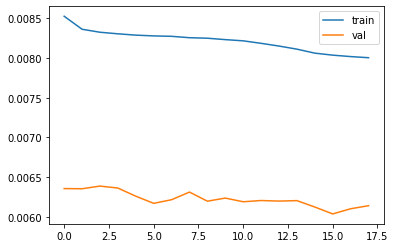

In [ ]:
plt.plot(sae.finetune_history.history['loss'], label='train')
plt.plot(sae.finetune_history.history['val_loss'], label='val')
plt.legend()

In [ ]:
print(np.mean(np.sqrt(sample_weight * mse(bert_embeddings, sae.decode(sae.encode(bert_embeddings))))))
print(np.mean(sample_weight * rmse(bert_embeddings, sae.decode(sae.encode(bert_embeddings).numpy()))))

0.08809406813009836
0.005937732


## Уишарт

In [ ]:
from collections import defaultdict
import scipy
import numpy as np
import sys

from itertools import  product
from scipy.special import gamma
from scipy.spatial.distance import  euclidean
from math import sqrt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KDTree

from sklearn.metrics import  silhouette_score, davies_bouldin_score, calinski_harabasz_score

import gc

def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))

    # print(max_diff)
    return max_diff >= h


class WishartClusterization:
    def __init__(self, wishart_neighbors, significance_level):
        self.wishart_neighbors = wishart_neighbors  # Number of neighbors
        self.significance_level = significance_level  # Significance level

    def fit(self, X):
        kdt = KDTree(X, metric='euclidean')
        print('KDTree has been built')
        #add one because you are your neighb.
        distances, neighbors = kdt.query(X, k = self.wishart_neighbors + 1, return_distance = True)
        neighbors = neighbors[:, 1:]


        distances = distances[:, -1]
        # print('distances')
        # print(' '.join(list(map(str, distances))))


        indexes = np.argsort(distances)
        # print('indexes sorted')
        # print(' '.join(list(map(str, indexes))))

        size, dim = X.shape

        self.object_labels = np.zeros(size, dtype = int) - 1

        #index in tuple
        #min_dist, max_dist, flag_to_significant
        self.clusters = np.array([(1., 1., 0)])
        self.clusters_to_objects = defaultdict(list)
        #print('Start clustering')
        counter_to_print = 0
        for index in indexes:

            if counter_to_print % 100000 == 0:
                print(counter_to_print)
                # print(' '.join(list(map(str, self.object_labels))), flush=True)

            counter_to_print += 1

            neighbors_clusters =\
                np.concatenate([self.object_labels[neighbors[index]], self.object_labels[neighbors[index]]])
            unique_clusters = np.unique(neighbors_clusters).astype(int)
            unique_clusters = unique_clusters[unique_clusters != -1]


            if len(unique_clusters) == 0:
                self._create_new_cluster(index, distances[index])
            else:
                max_cluster = unique_clusters[-1]
                min_cluster = unique_clusters[0]
                if max_cluster == min_cluster:
                    if self.clusters[max_cluster][-1] < 0.5:
                        self._add_elem_to_exist_cluster(index, distances[index], max_cluster)
                    else:
                        self._add_elem_to_noise(index)
                else:
                    my_clusters = self.clusters[unique_clusters]
                    flags = my_clusters[:, -1]
                    if np.min(flags) > 0.5:
                        self._add_elem_to_noise(index)
                    else:
                        significan = np.power(my_clusters[:, 0], -dim) - np.power(my_clusters[:, 1], -dim)
                        significan *= self.wishart_neighbors
                        significan /= size
                        significan /= np.power(np.pi, dim / 2)
                        significan *= gamma(dim / 2 + 1)
                        significan_index = significan >= self.significance_level

                        significan_clusters = unique_clusters[significan_index]
                        not_significan_clusters = unique_clusters[~significan_index]
                        significan_clusters_count = len(significan_clusters)
                        if significan_clusters_count > 1 or min_cluster == 0:
                            self._add_elem_to_noise(index)
                            self.clusters[significan_clusters, -1] = 1
                            for not_sig_cluster in not_significan_clusters:
                                if not_sig_cluster == 0:
                                    continue

                                for bad_index in self.clusters_to_objects[not_sig_cluster]:
                                    self._add_elem_to_noise(bad_index)
                                self.clusters_to_objects[not_sig_cluster].clear()
                        else:
                            for cur_cluster in unique_clusters:
                                if cur_cluster == min_cluster:
                                    continue

                                for bad_index in self.clusters_to_objects[cur_cluster]:
                                    self._add_elem_to_exist_cluster(bad_index, distances[bad_index], min_cluster)
                                self.clusters_to_objects[cur_cluster].clear()

                            self._add_elem_to_exist_cluster(index, distances[index], min_cluster)
        self.labels_ = self.clean_data()
        return self.labels_

    def clean_data(self):
        unique = np.unique(self.object_labels)
        index = np.argsort(unique)
        if unique[0] != 0:
            index += 1
        true_cluster = {unq :  index for unq, index in zip(unique, index)}
        result = np.zeros(len(self.object_labels), dtype = int)
        for index, unq in enumerate(self.object_labels):
            result[index] = true_cluster[unq]
        return result

    def _add_elem_to_noise(self, index):
        self.object_labels[index] = 0
        self.clusters_to_objects[0].append(index)

    def _create_new_cluster(self, index, dist):
        self.object_labels[index] = len(self.clusters)
        self.clusters_to_objects[len(self.clusters)].append(index)
        self.clusters = np.append(self.clusters, [(dist, dist, 0)], axis = 0)

    def _add_elem_to_exist_cluster(self, index, dist, cluster_label):
        self.object_labels[index] = cluster_label
        self.clusters_to_objects[cluster_label].append(index)
        self.clusters[cluster_label][0] = min(self.clusters[cluster_label][0], dist)
        self.clusters[cluster_label][1] = max(self.clusters[cluster_label][1], dist)

In [ ]:
!git clone https://github.com/jqmviegas/jqm_cvi.git
!wget https://raw.githubusercontent.com/iphysresearch/S_Dbw_validity_index/master/S_Dbw.py

Cloning into 'jqm_cvi'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.
--2021-06-05 19:06:54--  https://raw.githubusercontent.com/iphysresearch/S_Dbw_validity_index/master/S_Dbw.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4235 (4.1K) [text/plain]
Saving to: ‘S_Dbw.py’

S_Dbw.py            100%[===================>]   4.14K  --.-KB/s    in 0s      

2021-06-05 19:06:54 (45.7 MB/s) - ‘S_Dbw.py’ saved [4235/4235]



In [ ]:
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.special import gamma
from collections import defaultdict

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import cycle, islice
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from jqm_cvi.jqmcvi import base
from S_Dbw import S_Dbw
from sklearn.neighbors import NearestNeighbors

# utils
def volume(r, dim):
    """
    Helper function to calculate volumes of a dim-dimensional spheres with radiuses r
    param r: radiuses of a spheres of shape (n_samples,): ndarray
    param dim: dimensionality of a sphere: int

    Returns:
        volumes: ndarray
    """
    dim_const = (np.pi ** (dim / 2)) / gamma(dim / 2 + 1)
    return dim_const * (r ** dim)


def significant(cluster, h, p):
    """
    Helper function to tell if a cluster is significant
    param cluster: vertices in cluster (indexed): list
    h: height hyperparameter: double
    p: estimated saliency for all points
    """
    p_cluster = p[np.array(cluster)]
    pw_difference = np.abs(p_cluster[:, np.newaxis] - p_cluster)
    max_diff = pw_difference.max()

    # print(max_diff)
    return max_diff >= h


class ClusterValidation:
    def __init__(self, data, labels, dist='euclidean'):
        """
        @param data: ndarray of shape (n_samples, n_features)
        @param labels: ndarray of shape (n_samples,), cluster labels for each sample
        @param dist: distance metric to use: str or callable; defaults to 'euclidean'
        """
        self.data = data
        self.labels = labels
        self.dist = dist
        self.num_cluster = labels.max() + 1
        self.cluster_list = list(range(self.num_cluster))

    def RMSSTD(self):
        dof = self.data.shape[0] - self.num_cluster
        n_features = self.data.shape[1]
        result = 0
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            result += ((cluster_data - center) ** 2).sum()

        return (result / (dof * n_features)) ** (1 / 2)

    def RS(self):
        all_mean = ((self.data - self.data.mean(axis=0)) ** 2).sum()
        part_mean = 0

        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            part_mean += ((cluster_data - center) ** 2).sum()

        return (all_mean - part_mean) / all_mean

    def hubert(self):
        dist_matrix = squareform(pdist(self.data, self.dist))
        n = self.data.shape[0]

        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
        center_dist = squareform(pdist(centers, self.dist))

        result = 0
        for i in range(n):
            for j in range(n):
                result += (dist_matrix[i, j] * center_dist[self.labels[i], self.labels[j]])
        return (result * 2) / (n * (n-1)) 

    def CH(self):
        return calinski_harabasz_score(self.data, self.labels)

    def I_index(self):
        all_mean = np.sqrt(((self.data - self.data.mean(axis=0)) ** 2).sum())
        part_mean = 0
        centers = np.empty((self.num_cluster, self.data.shape[1]))

        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
            part_mean += np.sqrt(((cluster_data - center) ** 2).sum())
        center_dist = squareform(pdist(centers, self.dist))

        max_center_dist = center_dist.max()

        return (all_mean * max_center_dist) / (self.num_cluster * part_mean)

    def dunn(self):
        return base.dunn_fast(self.data, self.labels)

    def silhouette(self):
        return silhouette_score(self.data, self.labels)

    def davies_bouldin(self):
        return davies_bouldin_score(self.data, self.labels)

    def xie_beni(self):
        n = self.data.shape[0]
        part_mean = 0

        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
            part_mean += ((cluster_data - center) ** 2).sum()
        center_dist = squareform(pdist(centers, self.dist))

        center_dist = center_dist + np.diag(np.full_like(center_dist[0], center_dist.max()))

        return part_mean / (n * (center_dist.min()**2))

    def SD(self):
        scat, dis = 0, 0

        all_var_vector = np.var(self.data, 0)
        all_var = np.sqrt(np.sum(all_var_vector ** 2))
        part_var = 0

        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
            part_var_vector = np.var(cluster_data, 0)
            part_var += np.sqrt((part_var_vector ** 2).sum())
        center_dist = squareform(pdist(centers, self.dist))

        scat = part_var / (all_var * self.num_cluster)

        max_dist = center_dist.max()
        min_dist = (center_dist + np.diag(np.full_like(center_dist[0], max_dist))).min()
        sum_dist = np.sum(1.0 / np.sum(center_dist, axis=1))

        dis = (max_dist * sum_dist) / min_dist

        return scat + dis

    def S_Dbw(self):
        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center

        sdbw = S_Dbw(self.data, self.labels, centers)
        return sdbw.S_Dbw_result()

    def CVNN(self, n_neighbors=10):
        com = 0
        sep = []
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        neigh.fit(self.data)
        knbrs = neigh.kneighbors(return_distance=False)

        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            cluster_ind = np.arange(self.data.shape[0])[self.labels == cluster]
            n_i = cluster_data.shape[0]
            if (n_i > 1):
                com += np.sum(pdist(cluster_data, metric=self.dist)) * 2 / (n_i * (n_i-1))
            sep.append(np.isin(knbrs[cluster_ind], cluster_ind, invert=True).sum() / (n_i * n_neighbors))

        sep = np.max(sep)

        return com + sep

    def run_all(self, n_neighbors=10, calc_hubert=True):
        results = {}
        results['rmsstd'] = self.RMSSTD()
        results['r-squared'] = self.RS()
        if calc_hubert:
            results['hubert'] = self.hubert()
        results['ch_index'] = self.CH()
        results['i_index'] = self.I_index()
        try:
            results['dunn'] = self.dunn()
        except ValueError as e:
            print('dunn failed with')
            print(e)
            results['dunn'] = np.nan
        results['silhouette'] = self.silhouette()
        results['davies_bouldin'] = self.davies_bouldin()
        results['xie_beni'] = self.xie_beni()
        results['sd'] = self.SD()
        try:
            results['s_dbw'] = self.S_Dbw()
        except:
            results['s_dbw'] = np.nan
        results['cvnn'] = self.CVNN(n_neighbors)

        return results


1.2260036414029734


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from scipy.stats import ranksums, kstest, ks_2samp
from scipy.spatial.distance import cdist

def cluster_mean_intracluster(X, y):
    mean_intracluster_dist = []
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            mean_intracluster_dist.append(0)
            continue
        cluster_dist = squareform(pdist(X_cluster))
        n = X_cluster.shape[0]
        mean_intracluster_dist.append(2 * cluster_dist.sum() / (n * (n - 1)))
    return mean_intracluster_dist

def cluster_max_intracluster(X, y):
    max_intracluster_dist = []
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        cluster_dist = squareform(pdist(X_cluster))
        max_intracluster_dist.append(cluster_dist.max())
    return max_intracluster_dist

def cluster_centroid_dist(X, y):
    centroid_dist = []
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        centroid = np.mean(X_cluster, axis=0)
        c_dist = cdist(X_cluster, centroid.reshape(1, -1))
        centroid_dist.append(2 * c_dist.mean())
    return centroid_dist

def cluster_rmsstd(X, y):
    rmsstd_centroid_dist = []
    dof = X.shape[0] - len(np.unique(y))
    n_feat = X.shape[1]
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        centroid = np.mean(X_cluster, axis=0)
        centroid_dist = cdist(X_cluster, centroid.reshape(1, -1))
        rmsstd_centroid_dist.append((centroid_dist.sum() / (dof * n_feat)) ** (0.5))

    return rmsstd_centroid_dist

def cluster_sd_scat(X, y):
    sd_scat = []
    all_var_vector = np.var(X, 0)
    all_var = np.sqrt(np.sum(all_var_vector ** 2))
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        part_var_vector = np.var(X_cluster, 0)
        sd_scat.append(np.sqrt((part_var_vector ** 2).sum()))
    return sd_scat


def cluster_silhouette(X, y):
    result = []
    n_clusters = len(np.unique(y))
    for cluster_id in range(n_clusters):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        
        cluster_dist = squareform(pdist(X_cluster))
        n = X_cluster.shape[0]
        a = cluster_dist.sum(axis=1) / (n - 1)
        # other clusters
        b = None

        for other_cluster_id in range(n_clusters):
            if other_cluster_id == cluster_id:
                continue
            X_other_cluster = X[y == other_cluster_id]
            between_cluster_dist = cdist(X_cluster, X_other_cluster)
            mean_between = between_cluster_dist.mean(axis=1)

            if b is None:
                b = mean_between
            else:
                b = np.minimum(b, mean_between)
        
        result.append(np.mean((b - a) / np.maximum(a, b)) / n_clusters)

    return result

def cluster_db(X, y):
    n_clusters = len(np.unique(y))
    intra_dists = np.empty(n_clusters)
    centroids = np.empty((n_clusters, len(X[0])), dtype=float)

    for cluster_id in range(n_clusters):
        X_cluster = X[y == cluster_id]
        centroid = np.mean(X_cluster, axis=0)
        centroids[cluster_id] = centroid
        intra_dists[cluster_id] = np.mean(cdist(X_cluster, centroid.reshape(1, -1)))

    centroid_dist = squareform(pdist(centroids))

    centroid_dist[centroid_dist == 0] = np.inf
    intra_dists_between_clusters = intra_dists[:, None] + intra_dists
    scores = np.max(intra_dists_between_clusters / centroid_dist, axis=1)

    return scores

from sklearn.neighbors import NearestNeighbors
def cluster_cvnn_sep(X, y, n_neighbors=10):
    n_clusters = len(np.unique(y))
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(X)
    knbrs = neigh.kneighbors(return_distance=False)

    sep = []

    for cluster_id in range(n_clusters):
        X_cluster = X[y == cluster_id]
        cluster_ind = np.arange(X.shape[0])[y == cluster_id]
        n_i = X_cluster.shape[0]
        
        sep.append(np.isin(knbrs[cluster_ind], cluster_ind, invert=True).sum() / (n_i * n_neighbors))

    return sep

def run_all_stat_tests(X_real, y_real, X_gen, y_gen):
    wilcoxon_res = {}
    ks_res = {}
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

    # sizes
    _, real_sizes = np.unique(y_real, return_counts=True)
    _, gen_sizes = np.unique(y_gen, return_counts=True)
    wilcoxon_res['sizes'] = ranksums(real_sizes, gen_sizes)
    ks_res['sizes'] = ks_2samp(real_sizes, gen_sizes)

    sns.kdeplot(x=real_sizes, label='real', ax=axs[0][0])
    sns.kdeplot(x=gen_sizes, label='gen', ax=axs[0][0])
    axs[0][0].set_title('Sizes of clusters')
    axs[0][0].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['sizes'].pvalue,
                       ks_res['sizes'].pvalue),
                   transform=axs[0][0].transAxes)
    axs[0][0].legend()

    # mean intracluster
    stat_real = cluster_mean_intracluster(X_real, y_real)
    stat_gen = cluster_mean_intracluster(X_gen, y_gen)
    wilcoxon_res['mean_dist'] = ranksums(stat_real, stat_gen)
    ks_res['mean_dist'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[0][1])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[0][1])
    axs[0][1].set_title('Mean intracluster distance')
    axs[0][1].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['mean_dist'].pvalue,
                       ks_res['mean_dist'].pvalue),
                   transform=axs[0][1].transAxes)
    axs[0][1].legend()

    # max intracluster
    stat_real = cluster_max_intracluster(X_real, y_real)
    stat_gen = cluster_max_intracluster(X_gen, y_gen)
    wilcoxon_res['max_dist'] = ranksums(stat_real, stat_gen)
    ks_res['max_dist'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[0][2])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[0][2])
    axs[0][2].set_title('Max intracluster distance')
    axs[0][2].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['max_dist'].pvalue,
                       ks_res['max_dist'].pvalue),
                   transform=axs[0][2].transAxes)
    axs[0][2].legend()

    # centroid dist
    stat_real = cluster_centroid_dist(X_real, y_real)
    stat_gen = cluster_centroid_dist(X_gen, y_gen)
    wilcoxon_res['centroid_dist'] = ranksums(stat_real, stat_gen)
    ks_res['centroid_dist'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[1][0])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[1][0])
    axs[1][0].set_title('Centroid distance')
    axs[1][0].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['centroid_dist'].pvalue,
                       ks_res['centroid_dist'].pvalue),
                   transform=axs[1][0].transAxes)
    axs[1][0].legend()

    # rmsstd compactness
    stat_real = cluster_rmsstd(X_real, y_real)
    stat_gen = cluster_rmsstd(X_gen, y_gen)
    wilcoxon_res['rmsstd'] = ranksums(stat_real, stat_gen)
    ks_res['rmsstd'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[1][1])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[1][1])
    axs[1][1].set_title('RMSSTD Compactness')
    axs[1][1].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['rmsstd'].pvalue,
                       ks_res['rmsstd'].pvalue),
                   transform=axs[1][1].transAxes)
    axs[1][1].legend()

    # sd scattering
    stat_real = cluster_sd_scat(X_real, y_real)
    stat_gen = cluster_sd_scat(X_gen, y_gen)
    wilcoxon_res['sd_scat'] = ranksums(stat_real, stat_gen)
    ks_res['sd_scat'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[1][2])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[1][2])
    axs[1][2].set_title('SD scattering')
    axs[1][2].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['sd_scat'].pvalue,
                       ks_res['sd_scat'].pvalue),
                   transform=axs[1][2].transAxes)
    axs[1][2].legend()

    # silhouette index
    stat_real = cluster_silhouette(X_real, y_real)
    stat_gen = cluster_silhouette(X_gen, y_gen)
    wilcoxon_res['silhouette'] = ranksums(stat_real, stat_gen)
    ks_res['silhouette'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[2][0])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[2][0])
    axs[2][0].set_title('Silhouette index')
    axs[2][0].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['silhouette'].pvalue,
                       ks_res['silhouette'].pvalue),
                   transform=axs[2][0].transAxes)
    axs[2][0].legend()

    # db cluster scores
    stat_real = cluster_db(X_real, y_real)
    stat_gen = cluster_db(X_gen, y_gen)
    wilcoxon_res['db_score'] = ranksums(stat_real, stat_gen)
    ks_res['db_score'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[2][1])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[2][1])
    axs[2][1].set_title('DB cluster scores')
    axs[2][1].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['db_score'].pvalue,
                       ks_res['db_score'].pvalue),
                   transform=axs[2][1].transAxes)
    axs[2][1].legend()

    # cvnn separation
    stat_real = cluster_cvnn_sep(X_real, y_real)
    stat_gen = cluster_cvnn_sep(X_gen, y_gen)
    wilcoxon_res['cvnn_sep'] = ranksums(stat_real, stat_gen)
    ks_res['cvnn_sep'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[2][2])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[2][2])
    axs[2][2].set_title('CVNN separation')
    axs[2][2].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['cvnn_sep'].pvalue,
                       ks_res['cvnn_sep'].pvalue),
                   transform=axs[2][2].transAxes)
    axs[2][2].legend()

    # plt.tight_layout()
    plt.show()
    return fig, wilcoxon_res, ks_res

# Результаты

In [ ]:
def clusters_distr(labels, labels_g):
    print('real')
    print(Counter(labels).most_common())
    print('real')
    print(Counter(labels_g).most_common())
    
def get_ngrams_from_vectors(X, n=3):
    """
    :param X: данные (n_samples, n_features)
    :param n: количество векторов в n-грамме
    :return: массив уникальных n-грамм
    """
    X = np.asarray(X)
    ngrams = []
    for i in range(len(X) - n + 1):
        ngrams.append(encoder(np.asarray(X[i:i + n])).numpy().flatten())
        # ngrams.append(pca.transform(np.asarray(X[i:i + n])).flatten())
    return np.vstack(ngrams)

In [ ]:
with open('drive/MyDrive/Coursework2021/sticked_file.txt', 'r') as f:
    sentences = f.read().split('\n')
with open('drive/MyDrive/Coursework2021/big_eng_lstm_2000.txt', 'r') as f:
    sentences_g = f.read().split('\n')

tokens = []
for sentence in tqdm(sentences):
    tokens += tokenizer.tokenize(sentence)

tokens_g = []
for sentence in tqdm(sentences_g):
    tokens_g += tokenizer.tokenize(sentence)

  0%|          | 0/128003 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
embeddings = []
for w in tokens[:10_000]:
    embeddings.append(token2embed[w])

embeddings_g = []
for w in tokens_g[:10_000]:
    embeddings_g.append(token2embed[w])

In [ ]:
ngram_series = get_ngrams_from_vectors(embeddings)
ngram_series.shape

(9998, 48)

In [ ]:
ngram_series_g = get_ngrams_from_vectors(embeddings_g)
ngram_series_g.shape

(9998, 48)

In [ ]:
wishart = WishartClusterization(2, 1)
labels = wishart.fit(ngram_series)
labels

KDTree has been built
distances
11.048541267992109 0.0 0.0 12.353857601497516 16.211473181063752 14.278797596299224 8.352382067530131 10.158626804816977 10.866332958269394 13.141170472640699 13.330132288427398 11.65004628000329 9.748852722625855 7.2549709441921255 0.0 0.0 9.123613241142113 9.101535219756691 8.715650489372095 0.0 11.421766730157756 15.654251617320872 6.249867177821521 9.592042404960463 11.3613109889322 7.022040655072873 9.137000356633004 9.573966124203752 13.710410873175613 10.334411923372553 0.0 8.346129199755538 11.337596605942167 10.217421640667746 10.888913260201694 9.070145375633135 12.409325047913294 14.93954855522742 10.049060098288413 0.0 0.0 0.0 11.48188022922787 12.010811144339382 11.500364403643648 7.0279785734424856 0.0 0.0 0.0 11.357732010793221 12.157179011571758 12.243379244872537 9.658333231198695 10.861808109610386 13.622984055789368 16.127661110570497 14.584213996369684 8.628900578344252 8.445126565864234 7.882868837593493 6.973997109623793 12.92622217

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


array([ 64, 112,   0, ..., 172, 181, 142])

In [ ]:
Counter(labels).most_common(15)

[(0, 5649),
 (181, 415),
 (269, 327),
 (71, 207),
 (167, 201),
 (156, 168),
 (172, 141),
 (264, 129),
 (8, 122),
 (142, 103),
 (99, 90),
 (145, 85),
 (239, 79),
 (67, 72),
 (59, 63)]

In [ ]:
wishart_g = WishartClusterization(2, 1)
labels_g = wishart_g.fit(ngram_series_g)
Counter(labels_g).most_common(15)

KDTree has been built
distances
11.851436075513085 5.428131160394836 6.973997109623793 9.895065215851934 7.724047728429756 9.210890948433955 8.123231943859807 8.997309474564164 0.0 0.0 0.0 9.33060026712102 6.573800030767672 7.617010919241297 9.779005355513998 0.0 10.783432574091078 0.0 10.783432574091078 0.0 0.0 7.893324448062457 0.0 11.896901314819743 0.0 10.482965087238512 0.0 0.0 7.820142575068313 0.0 12.934321071701502 10.210295965379741 8.843658428642081 6.1652109340315775 6.1652109340315775 8.176065293754109 6.336034945653427 8.645320331989483 8.303871295136528 6.663099883922732 0.0 0.0 0.0 6.83171083511592 9.962958572491386 14.193828925384494 0.0 8.171903474604305 0.0 6.798297071289768 0.0 0.0 7.430664164742195 0.0 0.0 0.0 0.0 0.0 0.0 8.009267179180643 10.168836389370174 8.507511962021725 8.055035273162888 9.0972557049988 7.127617232153465 8.479469185713736 0.0 8.782120958427466 0.0 0.0 0.0 9.037521009627703 9.173217033851547 9.07372178387867 0.0 13.785606426221495 10.7292446466

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


[(0, 1898),
 (210, 107),
 (396, 80),
 (545, 70),
 (1473, 68),
 (199, 65),
 (804, 64),
 (279, 63),
 (226, 62),
 (153, 60),
 (1098, 56),
 (911, 55),
 (361, 55),
 (795, 51),
 (828, 48)]

In [ ]:
cv_real = ClusterValidation(ngram_series, labels)
print(cv_real.run_all())
cv_real = ClusterValidation(ngram_series_g, labels_g)
print(cv_real.run_all())

dunn failed with
zero-size array to reduction operation minimum which has no identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars


{'rmsstd': 2.498391951747154, 'r-squared': 0.37239915714634936, 'hubert': 906.1786549508334, 'ch_index': 16.90487826241177, 'i_index': 0.04783567813793386, 'dunn': nan, 'silhouette': -0.27932647, 'davies_bouldin': 1.628653488785345, 'xie_beni': inf, 'sd': inf, 's_dbw': nan, 'cvnn': 1744.9809052975527}
dunn failed with
zero-size array to reduction operation minimum which has no identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars


{'rmsstd': 1.5631907371939655, 'r-squared': 0.697459618047026, 'hubert': 1030.1731319707148, 'ch_index': 10.993280516189124, 'i_index': 0.0050417738190106426, 'dunn': nan, 'silhouette': -0.19244893, 'davies_bouldin': 1.4892117006670913, 'xie_beni': inf, 'sd': inf, 's_dbw': nan, 'cvnn': 3921.536306132022}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


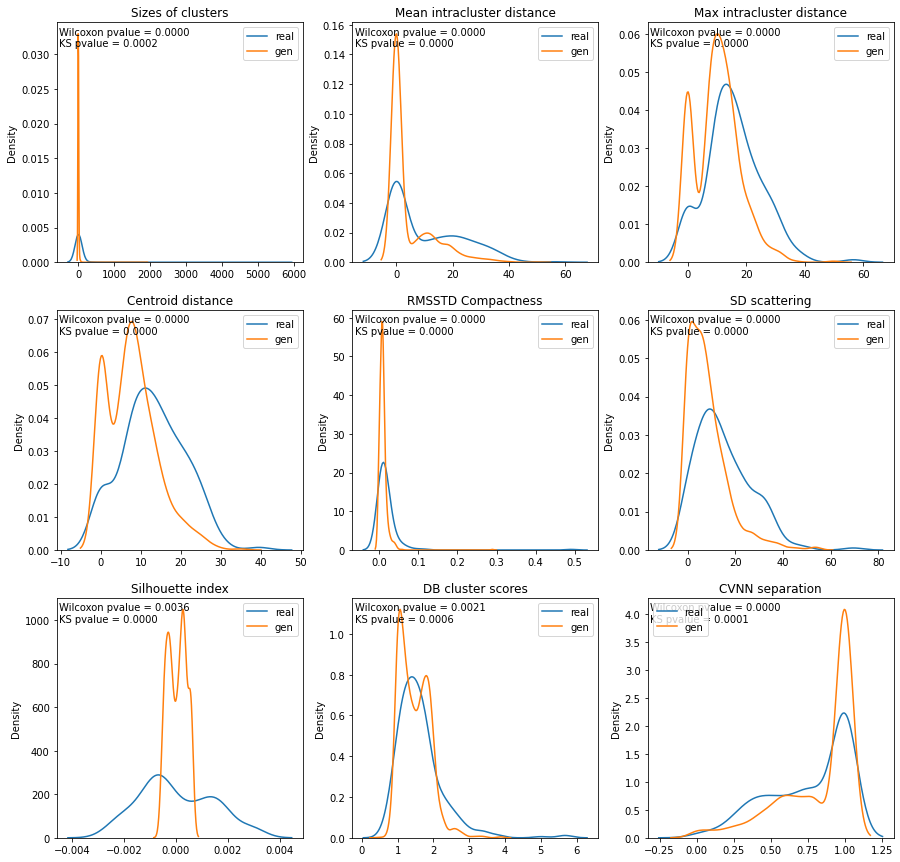

({'centroid_dist': RanksumsResult(statistic=8.601580088984338, pvalue=7.862600496759297e-18),
  'cvnn_sep': RanksumsResult(statistic=-4.106808705680493, pvalue=4.01163194811744e-05),
  'db_score': RanksumsResult(statistic=3.0758353610498697, pvalue=0.002099137185914229),
  'max_dist': RanksumsResult(statistic=7.5753870701991035, pvalue=3.5805845817412556e-14),
  'mean_dist': RanksumsResult(statistic=6.71447451006876, pvalue=1.8874516700704356e-11),
  'rmsstd': RanksumsResult(statistic=5.282787608711595, pvalue=1.2723286753921692e-07),
  'sd_scat': RanksumsResult(statistic=8.10223504297281, pvalue=5.395856634721093e-16),
  'silhouette': RanksumsResult(statistic=-2.909269131490286, pvalue=0.003622748463100244),
  'sizes': RanksumsResult(statistic=4.698829760248872, pvalue=2.616564424122083e-06)},
 {'centroid_dist': Ks_2sampResult(statistic=0.3333738158853534, pvalue=6.661338147750939e-15),
  'cvnn_sep': Ks_2sampResult(statistic=0.12883506343713957, pvalue=0.00014181137686997136),
  'db_s

In [ ]:
run_all_stat_tests(ngram_series, labels, ngram_series_g, labels_g)

In [ ]:
wishart = WishartClusterization(3, 1)
labels = wishart.fit(ngram_series)

wishart_g = WishartClusterization(3, 1)
labels_g = wishart_g.fit(ngram_series_g)

KDTree has been built
distances
11.430930281045935 0.0 0.0 14.879369893650182 17.28435718479137 15.034639264011966 10.197065091629566 10.385780235422033 13.261249978841256 13.259022273572144 13.389577333065454 11.80692529551444 10.81649883850771 7.331835196065751 0.0 0.0 10.18438916749296 9.89840708558307 9.0972557049988 0.0 14.05751382724686 15.65534897265094 8.826646269151214 9.592042404960463 11.70714315495715 9.298434978264444 9.6435474943612 9.573966124203752 14.996487107852081 10.808728813244665 0.0 8.723573928514293 12.28000604647831 10.717935205672228 10.888913260201694 9.070145375633135 12.63493972760046 15.130261720882807 10.858004867209376 0.0 0.0 0.0 11.64185014432235 12.787555557185811 11.519066144827953 7.163325842143401 0.0 8.189952518061789 0.0 11.591595308683768 14.190047505508824 13.157187804190627 10.504492020011739 11.258916563066483 13.622984055789368 16.524194772091533 14.713440746394042 9.12692181166729 8.532138807969714 9.498265785622662 7.582446796580862 14.041

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


KDTree has been built
distances
13.104783669390416 7.857325570831153 6.973997109623793 10.244033166433667 8.867830842684537 9.994593668083205 8.123231943859807 9.210890948433955 0.0 0.0 0.0 9.868800024062912 6.616866469255766 10.061496021385796 9.779005355513998 6.983748977901454 11.14366601617323 10.750646699841933 10.783432574091078 0.0 0.0 7.893324448062457 0.0 12.314704980844827 0.0 10.482965087238512 0.0 0.0 7.893324448062457 0.0 13.173725250988443 10.795625176372152 9.358926434473007 7.834542798733346 6.1652109340315775 8.660561389300828 6.336034945653427 9.620565082958157 8.303871295136528 6.973997109623793 0.0 0.0 0.0 9.324751666150771 9.962958572491386 15.326134944332813 0.0 8.180412677683131 0.0 6.798297071289768 0.0 0.0 9.523064490019328 0.0 0.0 5.698844312504929 0.0 10.000439185273896 0.0 8.009267179180643 10.168836389370174 11.127012437160909 8.507511962021725 9.0972557049988 7.127617232153465 8.619064161832839 8.479469185713736 8.839685612543281 0.0 0.0 5.184910989745652 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


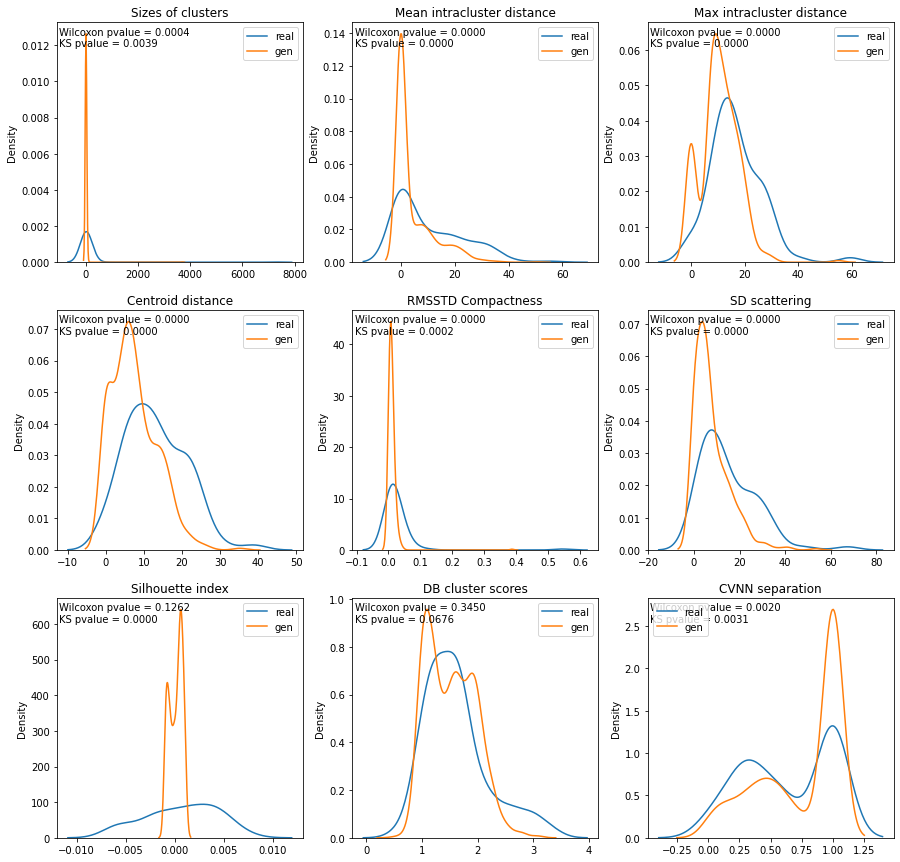

({'centroid_dist': RanksumsResult(statistic=6.002279912773824, pvalue=1.945658981589706e-09),
  'cvnn_sep': RanksumsResult(statistic=-3.0951342933023622, pvalue=0.001967238037391897),
  'db_score': RanksumsResult(statistic=0.9444193979656247, pvalue=0.34495537269761933),
  'max_dist': RanksumsResult(statistic=5.482925825462885, pvalue=4.183484560347599e-08),
  'mean_dist': RanksumsResult(statistic=4.780100248687672, pvalue=1.7520780741358084e-06),
  'rmsstd': RanksumsResult(statistic=4.52329625672786, pvalue=6.088392598255638e-06),
  'sd_scat': RanksumsResult(statistic=5.627832027601493, pvalue=1.8248866301063667e-08),
  'silhouette': RanksumsResult(statistic=1.5294229830440638, pvalue=0.1261596184408835),
  'sizes': RanksumsResult(statistic=3.550258873957733, pvalue=0.000384852507538972)},
 {'centroid_dist': Ks_2sampResult(statistic=0.34033741397161826, pvalue=2.678970207892206e-07),
  'cvnn_sep': Ks_2sampResult(statistic=0.1625904836902202, pvalue=0.0030531739557557724),
  'db_score'

In [ ]:
run_all_stat_tests(ngram_series, labels, ngram_series_g, labels_g)

In [ ]:
cv_real = ClusterValidation(ngram_series, labels)
print(cv_real.run_all())
cv_real = ClusterValidation(ngram_series_g, labels_g)
print(cv_real.run_all())

dunn failed with
zero-size array to reduction operation minimum which has no identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars


{'rmsstd': 2.608170106897828, 'r-squared': 0.3016583293828412, 'hubert': 726.127110360699, 'ch_index': 31.320496931861637, 'i_index': 0.1751473691092554, 'dunn': nan, 'silhouette': -0.24286778, 'davies_bouldin': 1.6145864553091112, 'xie_beni': inf, 'sd': inf, 's_dbw': nan, 'cvnn': 711.0778658494451}
dunn failed with
zero-size array to reduction operation minimum which has no identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars


{'rmsstd': 1.8084910229865527, 'r-squared': 0.5573281583577265, 'hubert': 866.0130924340815, 'ch_index': 11.810898135289321, 'i_index': 0.012464189383899536, 'dunn': nan, 'silhouette': -0.23736191, 'davies_bouldin': 1.5306078085034422, 'xie_beni': inf, 'sd': inf, 's_dbw': nan, 'cvnn': 2106.546561724621}


In [ ]:
wishart = WishartClusterization(4, 1)
labels = wishart.fit(ngram_series)

wishart_g = WishartClusterization(4, 1)
labels_g = wishart_g.fit(ngram_series_g)

KDTree has been built
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


KDTree has been built
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


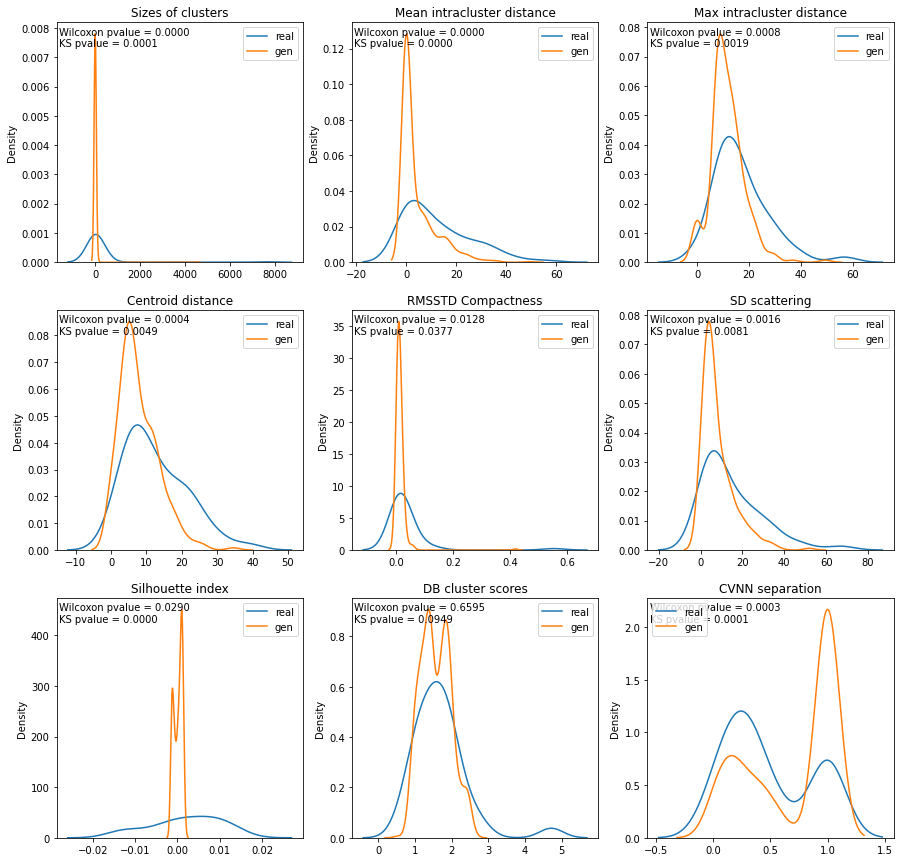

({'centroid_dist': RanksumsResult(statistic=3.5649629770178026, pvalue=0.00036390755348777597),
  'cvnn_sep': RanksumsResult(statistic=-3.6466851369279922, pvalue=0.00026564510179525854),
  'db_score': RanksumsResult(statistic=0.4406477298993459, pvalue=0.6594680430172286),
  'max_dist': RanksumsResult(statistic=3.3438867223632456, pvalue=0.000826134625203253),
  'mean_dist': RanksumsResult(statistic=5.023193776260794, pvalue=5.081922431518265e-07),
  'rmsstd': RanksumsResult(statistic=2.4881915719944296, pvalue=0.012839455059285172),
  'sd_scat': RanksumsResult(statistic=3.162690890116961, pvalue=0.0015631821418169226),
  'silhouette': RanksumsResult(statistic=2.1830196440006877, pvalue=0.029034363415933875),
  'sizes': RanksumsResult(statistic=4.339222209908749, pvalue=1.4298788546087953e-05)},
 {'centroid_dist': Ks_2sampResult(statistic=0.2703005115089514, pvalue=0.004934617372232775),
  'cvnn_sep': Ks_2sampResult(statistic=0.289087656529517, pvalue=7.319399281924266e-05),
  'db_sco

In [ ]:
run_all_stat_tests(ngram_series, labels, ngram_series_g, labels_g)

In [ ]:
cv_real = ClusterValidation(ngram_series, labels)
print(cv_real.run_all())
cv_real = ClusterValidation(ngram_series_g, labels_g)
print(cv_real.run_all())

dunn failed with
zero-size array to reduction operation minimum which has no identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars


{'rmsstd': 2.6488498605462945, 'r-squared': 0.27444507622630837, 'hubert': 660.399319914998, 'ch_index': 58.706334714537064, 'i_index': 0.45686457675739367, 'dunn': nan, 'silhouette': -0.21840757, 'davies_bouldin': 1.7096976323287731, 'xie_beni': inf, 'sd': inf, 's_dbw': nan, 'cvnn': 400.82177668861056}
dunn failed with
zero-size array to reduction operation minimum which has no identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars


{'rmsstd': 1.9047303276955954, 'r-squared': 0.4916216766808482, 'hubert': 784.7447175173685, 'ch_index': 14.044590697865328, 'i_index': 0.022346882645404804, 'dunn': nan, 'silhouette': -0.26605815, 'davies_bouldin': 1.5801873715314625, 'xie_beni': inf, 'sd': inf, 's_dbw': nan, 'cvnn': 1397.3813323603968}


Уникальные ngrams

In [ ]:
from typing import Iterable, Sequence, Optional

def unique_ngrams_from_tokens(tokens: Sequence[str], transformer: Iterable, n: int = 3, desired_cnt: Optional[int] = None) -> np.ndarray:
    """
    Набирает нграмм из текста
    :param tokens: текст в виде списка слов/токенов
    :param n: _n_-граммы
    :param desired_cnt: количество уникальных ngram на выходе. Если None --- целиком весь текст
    """
    unique_ngrams = set()
    for i in range(len(tokens) - n + 1):
        if desired_cnt and len(unique_ngrams) >= desired_cnt:
            print(f'unique_ngrams: took {i} ngrams to get {desired_cnt} unique')
            break
        unique_ngrams.add(' '.join(tokens[i:i + n]))
    ngrams_embed = []
    for ngram in unique_ngrams:
        ngram_embed = [token2embed[word] for word in ngram.split()]
        ngram_embed = np.asarray(ngram_embed)
        transformed_embed = np.asarray(transformer(ngram_embed))
        ngrams_embed.append(transformed_embed.flatten())
    return np.vstack(ngrams_embed)

In [ ]:
unique_ngrams = unique_ngrams_from_tokens(tokens, transformer=encoder, desired_cnt=10_000)
unique_ngrams_g = unique_ngrams_from_tokens(tokens_g, transformer=encoder, desired_cnt=10_000)

unique_ngrams: took 11068 ngrams to get 10000 unique
unique_ngrams: took 22423 ngrams to get 10000 unique


In [ ]:
unique_ngrams.shape

(10000, 48)

In [ ]:
wishart = WishartClusterization(3, 1)
labels = wishart.fit(unique_ngrams)

wishart_g = WishartClusterization(3, 1)
labels_g = wishart_g.fit(unique_ngrams_g)

KDTree has been built
0
KDTree has been built
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars


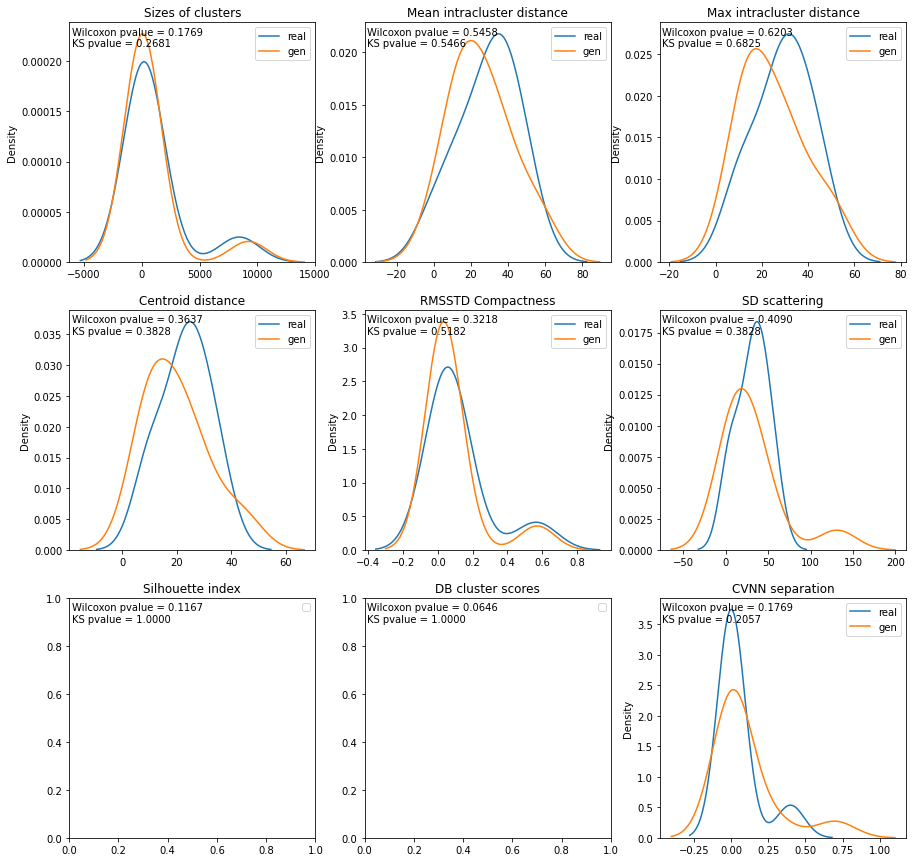

({'centroid_dist': RanksumsResult(statistic=0.9082951062292475, pvalue=0.3637223273807114),
  'cvnn_sep': RanksumsResult(statistic=-1.3502712035855329, pvalue=0.17692900573221848),
  'db_score': RanksumsResult(statistic=1.8477395417486238, pvalue=0.06464003076463333),
  'max_dist': RanksumsResult(statistic=0.49543369430686224, pvalue=0.620294015349161),
  'mean_dist': RanksumsResult(statistic=0.6040686963408962, pvalue=0.5457979706092143),
  'rmsstd': RanksumsResult(statistic=0.9908673886137245, pvalue=0.32175033823889176),
  'sd_scat': RanksumsResult(statistic=0.8257228238447705, pvalue=0.4089613420368744),
  'silhouette': RanksumsResult(statistic=1.568873365305064, pvalue=0.11667744915847059),
  'sizes': RanksumsResult(statistic=1.3502712035855329, pvalue=0.17692900573221848)},
 {'centroid_dist': Ks_2sampResult(statistic=0.38636363636363635, pvalue=0.38278955306819074),
  'cvnn_sep': Ks_2sampResult(statistic=0.4444444444444444, pvalue=0.20567482053550157),
  'db_score': Ks_2sampResul

In [ ]:
run_all_stat_tests(unique_ngrams, labels, unique_ngrams_g, labels_g)

In [ ]:
cv_real = ClusterValidation(unique_ngrams, labels)
print(cv_real.run_all())
cv_real = ClusterValidation(unique_ngrams_g, labels_g)
print(cv_real.run_all())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret,

{'rmsstd': 2.5659038819625106, 'r-squared': 0.31370575873428475, 'hubert': 708.7644170976266, 'ch_index': 570.8631303971185, 'i_index': nan, 'dunn': 0.23181309416954868, 'silhouette': 0.29030478, 'davies_bouldin': 1.112087895395004, 'xie_beni': nan, 'sd': nan, 's_dbw': nan, 'cvnn': nan}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret,

{'rmsstd': 2.4660052563803143, 'r-squared': 0.1689895928919103, 'hubert': 305.9364217926962, 'ch_index': 184.64709278669565, 'i_index': nan, 'dunn': 0.17438473419282235, 'silhouette': -0.008276242, 'davies_bouldin': 1.2407646579418918, 'xie_beni': nan, 'sd': nan, 's_dbw': nan, 'cvnn': nan}


In [ ]:
Counter(labels).most_common()

[(5, 8431),
 (1, 487),
 (8, 423),
 (9, 302),
 (2, 162),
 (7, 122),
 (3, 35),
 (4, 31),
 (6, 7)]

In [ ]:
Counter(labels_g).most_common()

[(9, 9227),
 (2, 317),
 (4, 186),
 (6, 79),
 (7, 49),
 (1, 42),
 (8, 38),
 (3, 27),
 (5, 19),
 (11, 8),
 (12, 4),
 (10, 4)]

In [ ]:
wishart = WishartClusterization(2, 1)
labels = wishart.fit(unique_ngrams)

wishart_g = WishartClusterization(2, 1)
labels_g = wishart_g.fit(unique_ngrams_g)

KDTree has been built
0
KDTree has been built
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars


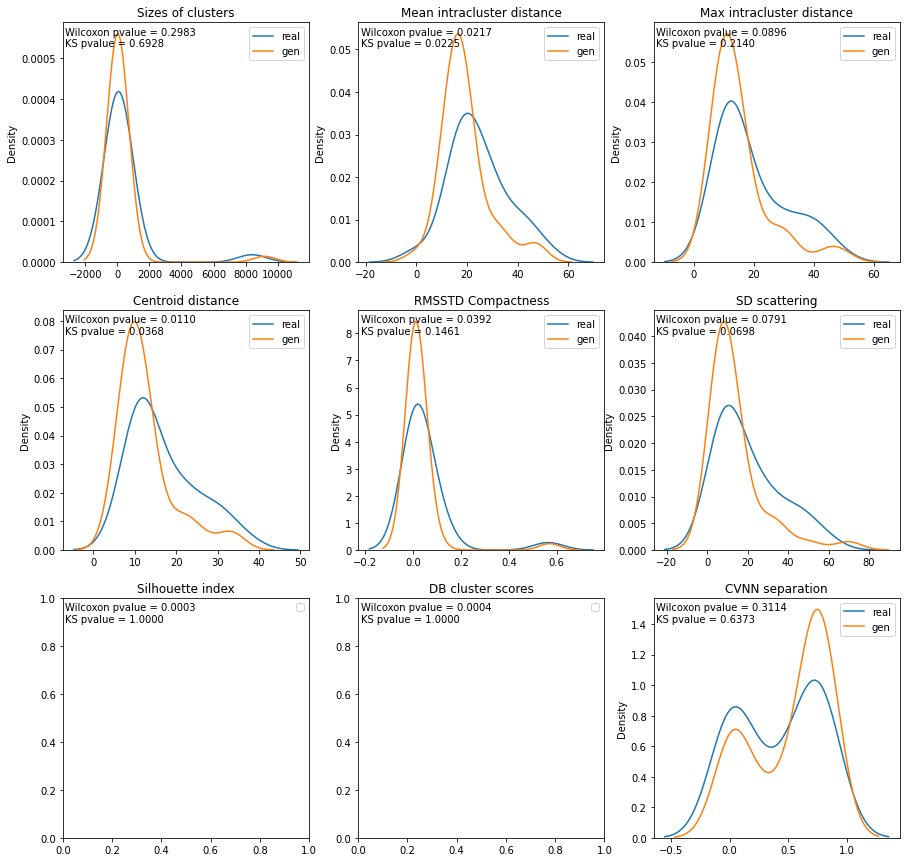

({'centroid_dist': RanksumsResult(statistic=2.542843065813383, pvalue=0.010995460169545194),
  'cvnn_sep': RanksumsResult(statistic=-1.012327858111043, pvalue=0.3113813191795165),
  'db_score': RanksumsResult(statistic=3.5500812558414663, pvalue=0.0003851122643959738),
  'max_dist': RanksumsResult(statistic=1.6976574049699664, pvalue=0.08957244148176806),
  'mean_dist': RanksumsResult(statistic=2.2950720618818856, pvalue=0.02172899486957984),
  'rmsstd': RanksumsResult(statistic=2.0619615691266118, pvalue=0.03921139496534467),
  'sd_scat': RanksumsResult(statistic=1.7559460712350297, pvalue=0.0790976172922406),
  'silhouette': RanksumsResult(statistic=3.621183391717053, pvalue=0.0002932585360171733),
  'sizes': RanksumsResult(statistic=1.0400628679223047, pvalue=0.2983106935567198)},
 {'centroid_dist': Ks_2sampResult(statistic=0.35674470457079155, pvalue=0.036783240714059584),
  'cvnn_sep': Ks_2sampResult(statistic=0.18333333333333332, pvalue=0.6373057889898324),
  'db_score': Ks_2samp

In [ ]:
run_all_stat_tests(unique_ngrams, labels, unique_ngrams_g, labels_g)

In [ ]:
Counter(labels).most_common()

[(7, 8405),
 (1, 449),
 (3, 423),
 (12, 302),
 (2, 152),
 (11, 112),
 (4, 35),
 (6, 31),
 (10, 23),
 (5, 10),
 (17, 7),
 (8, 7),
 (9, 6),
 (14, 5),
 (18, 4),
 (13, 4),
 (20, 4),
 (22, 3),
 (19, 3),
 (23, 3),
 (15, 3),
 (24, 3),
 (16, 3),
 (21, 3)]

In [ ]:
Counter(labels_g).most_common()

[(18, 9181),
 (1, 219),
 (6, 183),
 (8, 66),
 (2, 42),
 (16, 39),
 (14, 39),
 (15, 38),
 (5, 36),
 (12, 19),
 (4, 15),
 (3, 12),
 (21, 8),
 (9, 7),
 (17, 6),
 (26, 6),
 (10, 5),
 (28, 5),
 (11, 4),
 (22, 4),
 (13, 4),
 (24, 4),
 (19, 4),
 (33, 4),
 (7, 4),
 (37, 4),
 (38, 3),
 (32, 3),
 (39, 3),
 (40, 3),
 (30, 3),
 (35, 3),
 (31, 3),
 (23, 3),
 (27, 3),
 (34, 3),
 (25, 3),
 (36, 3),
 (29, 3),
 (20, 3)]

In [ ]:
wishart = WishartClusterization(1, 0.01)
labels = wishart.fit(unique_ngrams)

wishart_g = WishartClusterization(1, 0.01)
labels_g = wishart_g.fit(unique_ngrams_g)

clusters_distr(labels, labels_g)

KDTree has been built
0
KDTree has been built
0
real
[(144, 45), (1124, 44), (32, 31), (409, 30), (193, 27), (246, 26), (64, 26), (995, 26), (275, 23), (198, 23), (392, 22), (473, 22), (242, 22), (765, 22), (1354, 22), (1039, 21), (118, 20), (240, 20), (128, 20), (445, 20), (654, 20), (57, 19), (787, 19), (223, 19), (1274, 19), (262, 19), (247, 19), (106, 18), (135, 18), (385, 18), (1208, 18), (655, 18), (675, 18), (988, 17), (795, 17), (1111, 17), (187, 17), (342, 17), (305, 17), (512, 17), (123, 16), (947, 16), (306, 16), (343, 16), (1087, 16), (446, 16), (237, 16), (21, 16), (1199, 16), (918, 16), (105, 16), (822, 15), (737, 15), (472, 15), (215, 15), (1490, 15), (210, 15), (137, 15), (180, 15), (382, 15), (1046, 15), (1384, 15), (252, 15), (595, 15), (724, 15), (413, 15), (1464, 15), (398, 14), (149, 14), (263, 14), (388, 14), (621, 14), (276, 14), (302, 14), (132, 14), (124, 14), (403, 14), (483, 14), (1489, 14), (348, 14), (177, 14), (536, 14), (74, 14), (440, 13), (241, 13), (66

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars


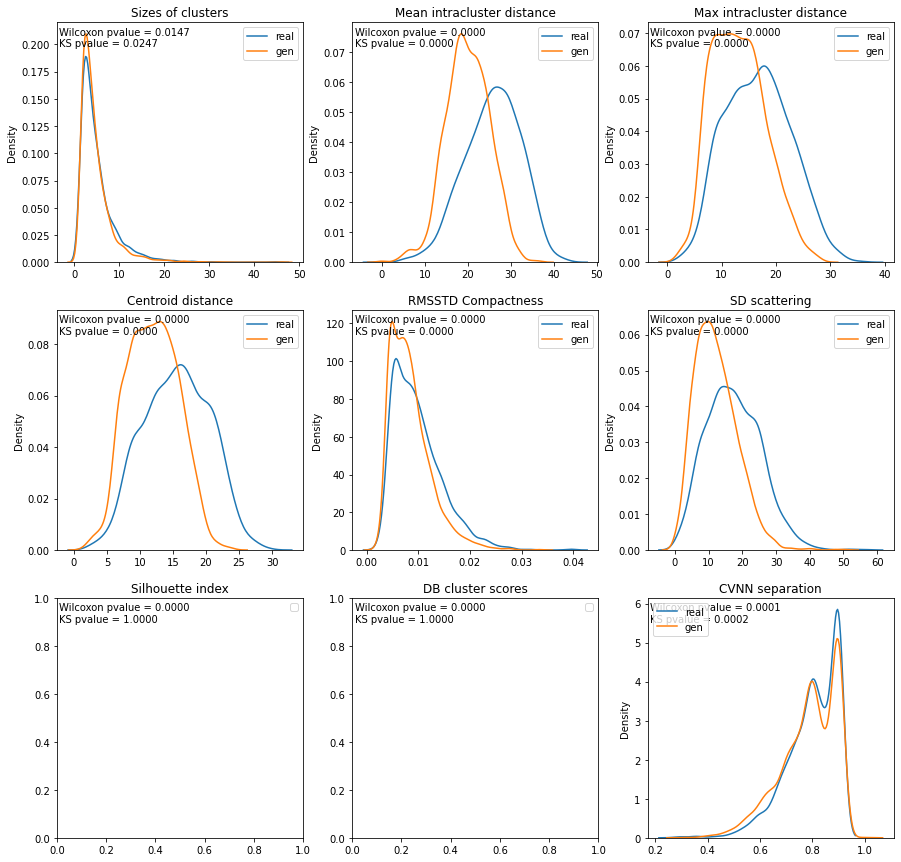

({'centroid_dist': RanksumsResult(statistic=23.19186100448965, pvalue=5.501243961263124e-119),
  'cvnn_sep': RanksumsResult(statistic=3.909120249912873, pvalue=9.263284796556244e-05),
  'db_score': RanksumsResult(statistic=52.47473848180559, pvalue=0.0),
  'max_dist': RanksumsResult(statistic=19.127558276349937, pvalue=1.4888639883895553e-81),
  'mean_dist': RanksumsResult(statistic=28.70093023423072, pvalue=3.7146055012889475e-181),
  'rmsstd': RanksumsResult(statistic=10.140567714043705, pvalue=3.649722862723603e-24),
  'sd_scat': RanksumsResult(statistic=21.425916662820395, pvalue=7.661194281627011e-102),
  'silhouette': RanksumsResult(statistic=52.47744494887698, pvalue=0.0),
  'sizes': RanksumsResult(statistic=2.439462321070094, pvalue=0.014709136512671054)},
 {'centroid_dist': Ks_2sampResult(statistic=0.32260343222514465, pvalue=2.404142440681767e-10),
  'cvnn_sep': Ks_2sampResult(statistic=0.06781228775330832, pvalue=0.00016541467084107975),
  'db_score': Ks_2sampResult(statisti

In [ ]:
run_all_stat_tests(unique_ngrams, labels, unique_ngrams_g, labels_g)

In [ ]:
cv_real = ClusterValidation(unique_ngrams, labels)
print(cv_real.run_all())
cv_real = ClusterValidation(unique_ngrams_g, labels_g)
print(cv_real.run_all())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret,

{'rmsstd': 1.550385785812206, 'r-squared': 0.7983242330907641, 'hubert': 1634.368459609002, 'ch_index': 16.266678958743096, 'i_index': nan, 'dunn': 0.1204565434236686, 'silhouette': 0.027835513, 'davies_bouldin': 1.7269062457682443, 'xie_beni': nan, 'sd': nan, 's_dbw': nan, 'cvnn': nan}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret,

{'rmsstd': 1.2048708030928537, 'r-squared': 0.8432341525756784, 'hubert': 1283.6966443118004, 'ch_index': 20.159533588665276, 'i_index': nan, 'dunn': 0.07871162976345106, 'silhouette': 0.05903567, 'davies_bouldin': 1.5363743557897065, 'xie_beni': nan, 'sd': nan, 's_dbw': nan, 'cvnn': nan}


## Размерность 50

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import InputLayer, Dense
from keras.models import Model, Sequential

ORIGINAL_DIM = 128
TARGET_DIM = 50

encoder = Sequential([
    InputLayer(input_shape=(ORIGINAL_DIM,)),
    Dense(80, activation='LeakyReLU'),
    Dense(TARGET_DIM, activation='LeakyReLU')
])

decoder = Sequential([
    InputLayer(input_shape=(TARGET_DIM,)),
    Dense(80, activation='LeakyReLU'),
    Dense(ORIGINAL_DIM, activation=None)
])

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def root_mean_squared_error_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
autoencoder.fit(bert_embeddings, bert_embeddings, batch_size=32, epochs=18, validation_split=0.1, sample_weight=sample_weight)

Epoch 1/18
859/859 [==============================] - 3s 3ms/step - loss: 0.0186 - val_loss: 0.0041
Epoch 2/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 3/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 5/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/18
859/859 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0018

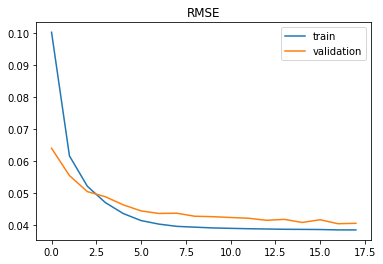

0.002618509
0.03853783105350022


In [ ]:
plt.plot(np.sqrt(autoencoder.history.history['loss']), label='train')
plt.plot(np.sqrt(autoencoder.history.history['val_loss']), label='validation')
plt.legend()
plt.title('RMSE')
plt.show()

print(np.mean(sample_weight * rmse(bert_embeddings, autoencoder(bert_embeddings).numpy())))

print(np.mean(np.sqrt(sample_weight * mse(bert_embeddings, autoencoder(bert_embeddings)))))

In [ ]:
unique_ngrams = unique_ngrams_from_tokens(tokens, transformer=encoder, desired_cnt=10_000)
unique_ngrams_g = unique_ngrams_from_tokens(tokens_g, transformer=encoder, desired_cnt=10_000)

unique_ngrams: took 11068 ngrams to get 10000 unique
unique_ngrams: took 22423 ngrams to get 10000 unique


In [ ]:
wishart = WishartClusterization(2, 0.1)
labels = wishart.fit(unique_ngrams)

wishart_g = WishartClusterization(2, 0.1)
labels_g = wishart_g.fit(unique_ngrams_g)

clusters_distr(labels, labels_g)

KDTree has been built
0
KDTree has been built
0
real
[(10, 8377), (1, 457), (7, 419), (12, 296), (4, 152), (9, 122), (5, 35), (2, 31), (14, 12), (6, 10), (19, 9), (8, 7), (23, 6), (16, 6), (3, 6), (21, 5), (26, 5), (29, 4), (20, 4), (25, 4), (13, 4), (24, 4), (17, 4), (11, 3), (30, 3), (28, 3), (27, 3), (22, 3), (15, 3), (18, 3)]
real
[(23, 9169), (2, 207), (8, 171), (1, 147), (11, 37), (19, 36), (7, 23), (3, 17), (18, 17), (17, 13), (4, 11), (26, 8), (12, 8), (21, 8), (28, 7), (31, 6), (15, 5), (41, 5), (5, 5), (36, 5), (9, 5), (14, 5), (39, 4), (16, 4), (29, 4), (40, 4), (34, 4), (33, 4), (42, 4), (30, 4), (45, 4), (38, 4), (27, 4), (10, 4), (13, 3), (32, 3), (43, 3), (25, 3), (35, 3), (22, 3), (37, 3), (24, 3), (6, 3), (44, 3), (46, 3), (20, 3), (0, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars


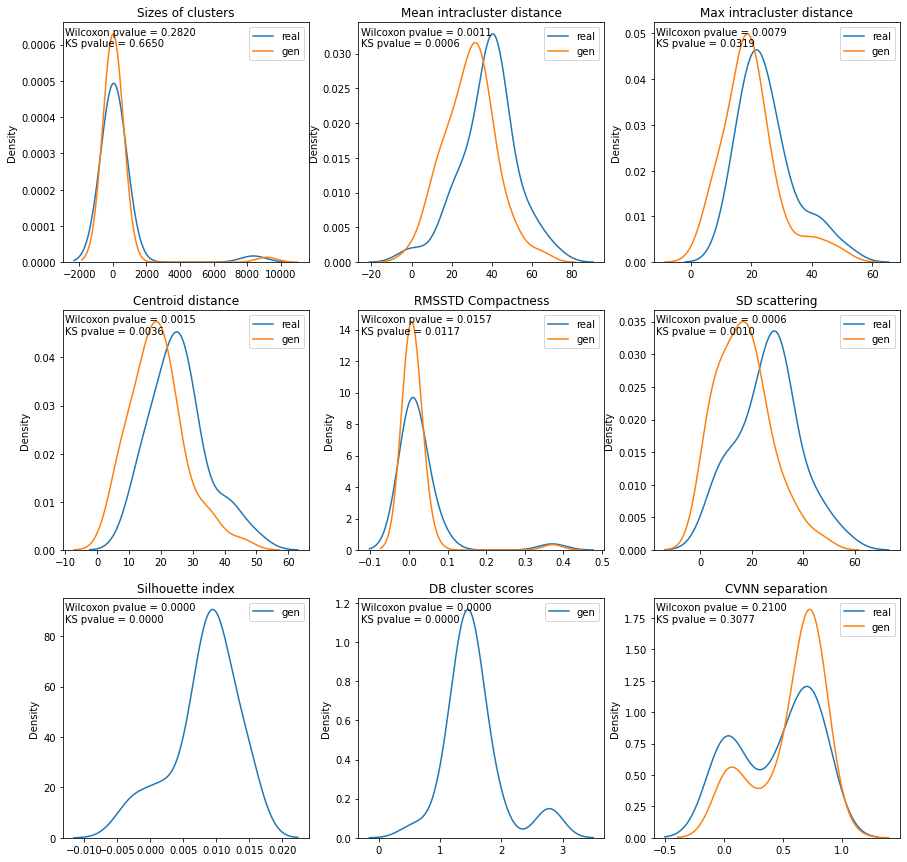

({'centroid_dist': RanksumsResult(statistic=3.1767918767625956, pvalue=0.0014891385920089283),
  'cvnn_sep': RanksumsResult(statistic=-1.2534730801593326, pvalue=0.2100335900226954),
  'db_score': RanksumsResult(statistic=7.364154345936078, pvalue=1.7827333669011242e-13),
  'max_dist': RanksumsResult(statistic=2.654579513459155, pvalue=0.00794073226427733),
  'mean_dist': RanksumsResult(statistic=3.253807203913601, pvalue=0.001138695313941792),
  'rmsstd': RanksumsResult(statistic=2.415232180278412, pvalue=0.015725182203303954),
  'sd_scat': RanksumsResult(statistic=3.416139209943339, pvalue=0.0006351576790859351),
  'silhouette': RanksumsResult(statistic=7.2565759650707236, pvalue=3.970118070476988e-13),
  'sizes': RanksumsResult(statistic=1.0758977271367605, pvalue=0.2819729985440277)},
 {'centroid_dist': Ks_2sampResult(statistic=0.4070464767616192, pvalue=0.0036180907224787617),
  'cvnn_sep': Ks_2sampResult(statistic=0.2148936170212766, pvalue=0.3077438653938541),
  'db_score': Ks_2

In [ ]:
run_all_stat_tests(unique_ngrams, labels, unique_ngrams_g, labels_g)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars


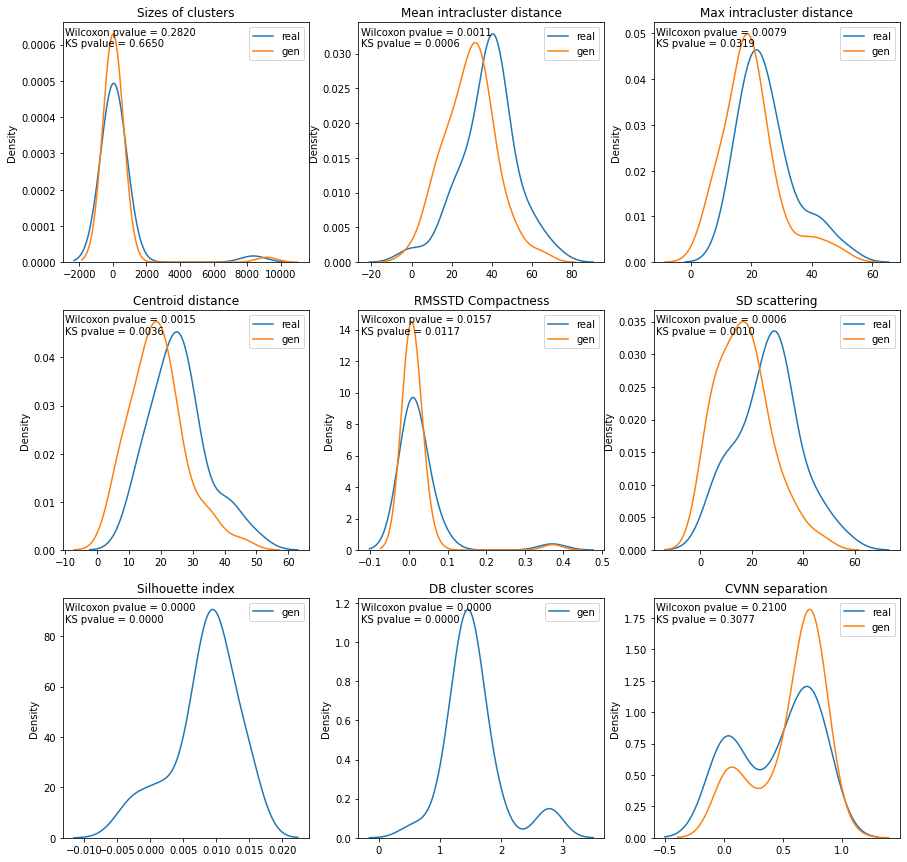

({'centroid_dist': RanksumsResult(statistic=3.1767918767625956, pvalue=0.0014891385920089283),
  'cvnn_sep': RanksumsResult(statistic=-1.2534730801593326, pvalue=0.2100335900226954),
  'db_score': RanksumsResult(statistic=7.364154345936078, pvalue=1.7827333669011242e-13),
  'max_dist': RanksumsResult(statistic=2.654579513459155, pvalue=0.00794073226427733),
  'mean_dist': RanksumsResult(statistic=3.253807203913601, pvalue=0.001138695313941792),
  'rmsstd': RanksumsResult(statistic=2.415232180278412, pvalue=0.015725182203303954),
  'sd_scat': RanksumsResult(statistic=3.416139209943339, pvalue=0.0006351576790859351),
  'silhouette': RanksumsResult(statistic=7.2565759650707236, pvalue=3.970118070476988e-13),
  'sizes': RanksumsResult(statistic=1.0758977271367605, pvalue=0.2819729985440277)},
 {'centroid_dist': Ks_2sampResult(statistic=0.4070464767616192, pvalue=0.0036180907224787617),
  'cvnn_sep': Ks_2sampResult(statistic=0.2148936170212766, pvalue=0.3077438653938541),
  'db_score': Ks_2

In [ ]:
f, w, k = run_all_stat_tests(unique_ngrams, labels, unique_ngrams_g, labels_g)
w, k

In [ ]:
f.savefig('drive/MyDrive/Coursework2021/2_01_unique_bert50.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_meth

ValueError: ignored

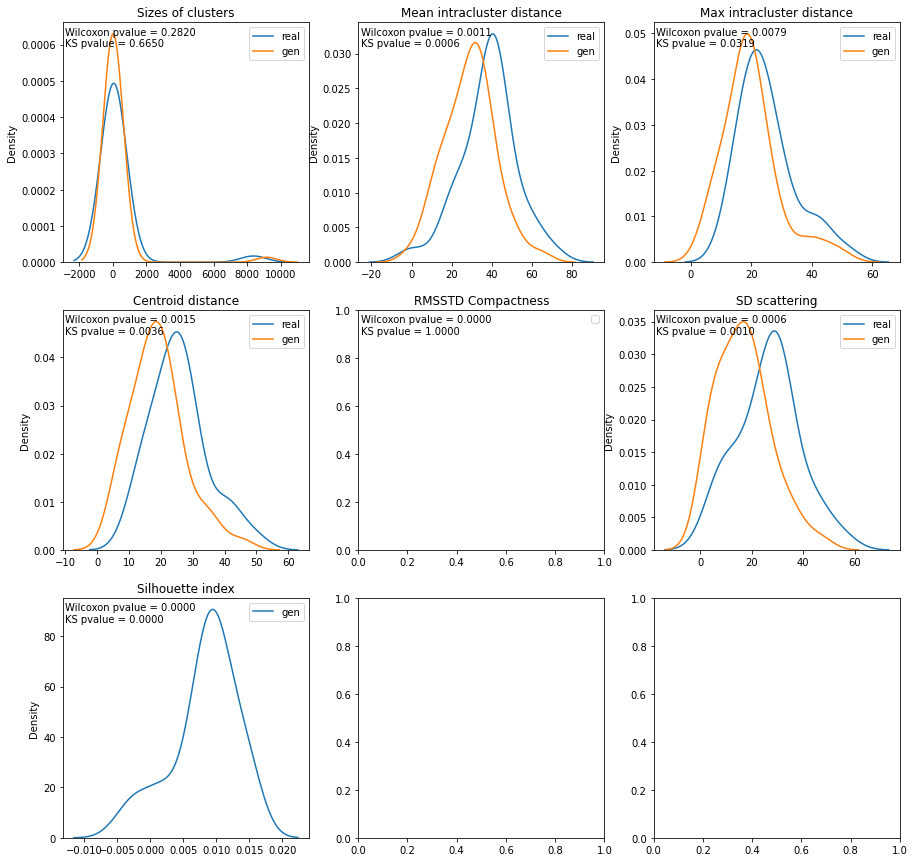

In [ ]:
not_noize = labels != Counter(labels).most_common(1)[0]
not_noize_g = labels != Counter(labels_g).most_common(1)[0]

f, w, k = run_all_stat_tests(unique_ngrams[not_noize], labels[not_noize], unique_ngrams_g[not_noize_g], labels_g[not_noize_g])
w, k

# Кластеризация обученных w2v

In [ ]:
import gensim

# model32_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size32_unnormed.kv')
model16_u = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/Coursework2021/cbow/mincnt10_window5_size16_unnormed.kv')

In [ ]:
tokens = []
for sentence in sentences[20:]:
    for word in sentence.split():
        if len(tokens) == 100_000:
            break
        tokens.append(word)

In [ ]:
from typing import Iterable, Sequence, Optional

def unique_ngrams_from_tokens_w2v(tokens: Sequence[str], w2v_model: object, n: int = 3, desired_cnt: Optional[int] = None) -> np.ndarray:
    """
    Набирает нграмм из текста ДЛЯ WORD2VEC
    :param tokens: текст в виде списка слов/токенов
    :param n: _n_-граммы
    :param desired_cnt: количество уникальных ngram на выходе. Если None --- целиком весь текст
    """
    # unique_ngrams = set()
    unique_ngrams = []
    for i in range(len(tokens) - n + 1):
        if desired_cnt and len(unique_ngrams) >= desired_cnt * 4:
            print(f'unique_ngrams: took {i} ngrams to get {desired_cnt} unique')
            break
        unique_ngrams.append(' '.join(tokens[i:i + n]))
    ngrams_embed = []
    for ngram in unique_ngrams:
        if len(ngrams_embed) == desired_cnt:
            break
        try:
            ngram_embed = [w2v_model.get_vector(word.lower()) for word in ngram.split()]
            ngrams_embed.append(np.asarray(ngram_embed).flatten())
        except KeyError:
            pass#print(ngram, file=sys.stderr)
    return np.vstack(ngrams_embed)

In [ ]:
ngrams = unique_ngrams_from_tokens_w2v(tokens, model16_u, n=2, desired_cnt=20_000)
ngrams.shape

unique_ngrams: took 80000 ngrams to get 20000 unique


(20000, 32)

In [ ]:
tokens_g = []
for sentence in sentences_g[50:]:
    for word in sentence.split():
        if len(tokens_g) == 100_000:
            break
        tokens_g.append(word)

In [ ]:
ngrams_g = unique_ngrams_from_tokens_w2v(tokens_g, model16_u, n=3, desired_cnt=20_000)
ngrams_g.shape

unique_ngrams: took 80000 ngrams to get 20000 unique


(20000, 48)

In [ ]:
wishart = WishartClusterization(2, 0.5)
labels = wishart.fit(ngrams[:10000])

wishart_g = WishartClusterization(2, 0.5)
labels_g = wishart_g.fit(ngrams_g[:10000])

clusters_distr(labels, labels_g)

KDTree has been built
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


KDTree has been built
0
real
[(0, 3272), (1100, 174), (1328, 161), (157, 126), (836, 121), (556, 106), (722, 91), (858, 75), (1336, 71), (1322, 64), (1331, 57), (1337, 54), (943, 52), (323, 50), (593, 49), (892, 47), (634, 44), (376, 43), (1327, 42), (620, 42), (827, 41), (1264, 41), (1198, 40), (651, 39), (746, 39), (766, 37), (399, 35), (389, 35), (957, 34), (1009, 34), (524, 34), (603, 34), (809, 33), (484, 32), (201, 31), (879, 28), (284, 28), (52, 28), (324, 28), (7, 27), (125, 27), (987, 27), (98, 26), (437, 25), (711, 24), (277, 24), (562, 24), (912, 23), (1283, 23), (983, 23), (241, 22), (533, 21), (501, 21), (94, 21), (169, 20), (850, 20), (311, 19), (857, 19), (1231, 19), (47, 19), (1334, 19), (1301, 18), (820, 18), (842, 18), (1332, 18), (988, 17), (785, 17), (972, 17), (1027, 17), (688, 17), (338, 16), (156, 16), (327, 16), (1005, 16), (572, 15), (1284, 15), (382, 15), (378, 15), (905, 15), (469, 15), (237, 15), (577, 14), (1303, 14), (1073, 14), (790, 14), (551, 14), (512,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


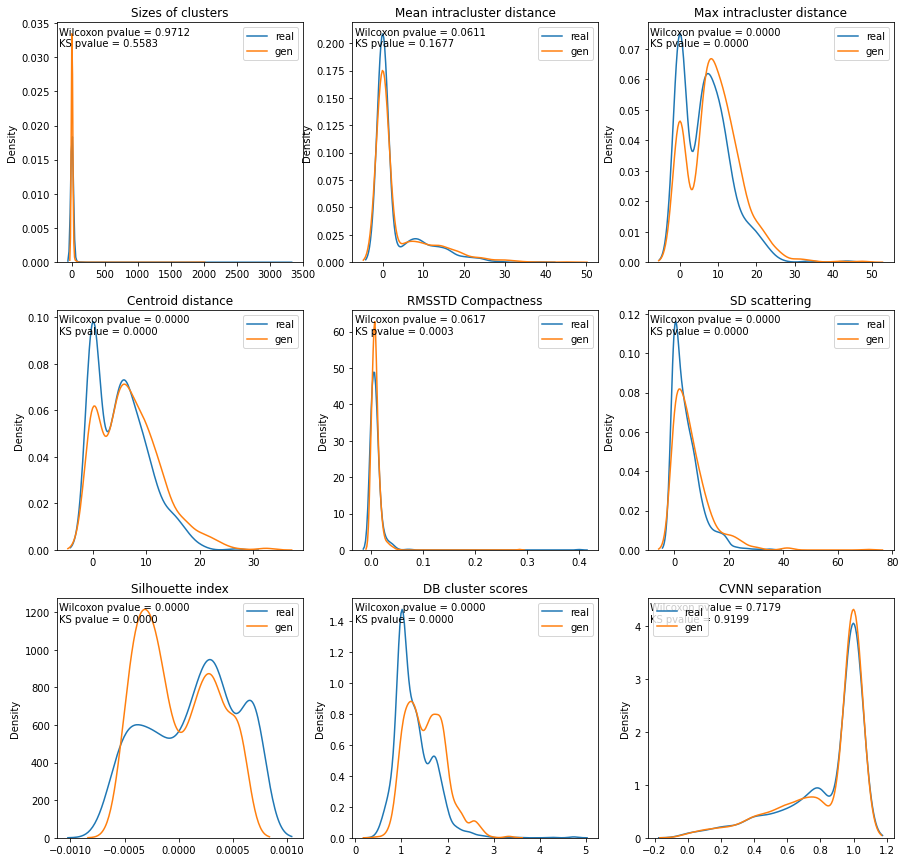

({'centroid_dist': RanksumsResult(statistic=-5.251761524156545, pvalue=1.5065143563499125e-07),
  'cvnn_sep': RanksumsResult(statistic=-0.3612142798156444, pvalue=0.7179392680321857),
  'db_score': RanksumsResult(statistic=-18.132690337196696, pvalue=1.7593703167158383e-73),
  'max_dist': RanksumsResult(statistic=-6.440857523943663, pvalue=1.188003552301955e-10),
  'mean_dist': RanksumsResult(statistic=-1.8725861765731115, pvalue=0.061125551664198856),
  'rmsstd': RanksumsResult(statistic=-1.8682767769586375, pvalue=0.06172350187971755),
  'sd_scat': RanksumsResult(statistic=-5.350530203379509, pvalue=8.769691408764672e-08),
  'silhouette': RanksumsResult(statistic=6.576591404118417, pvalue=4.813551437456059e-11),
  'sizes': RanksumsResult(statistic=0.036091398736645755, pvalue=0.9712094806751623)},
 {'centroid_dist': Ks_2sampResult(statistic=0.12692145862552595, pvalue=4.840393406935206e-05),
  'cvnn_sep': Ks_2sampResult(statistic=0.01923024004549582, pvalue=0.9199262987443975),
  'db

In [ ]:
f, w, k = run_all_stat_tests(ngrams[:10000], labels, ngrams_g[:10000], labels_g)
w, k

In [ ]:
f.savefig('drive/MyDrive/Coursework2021/w2v.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in long_scalars


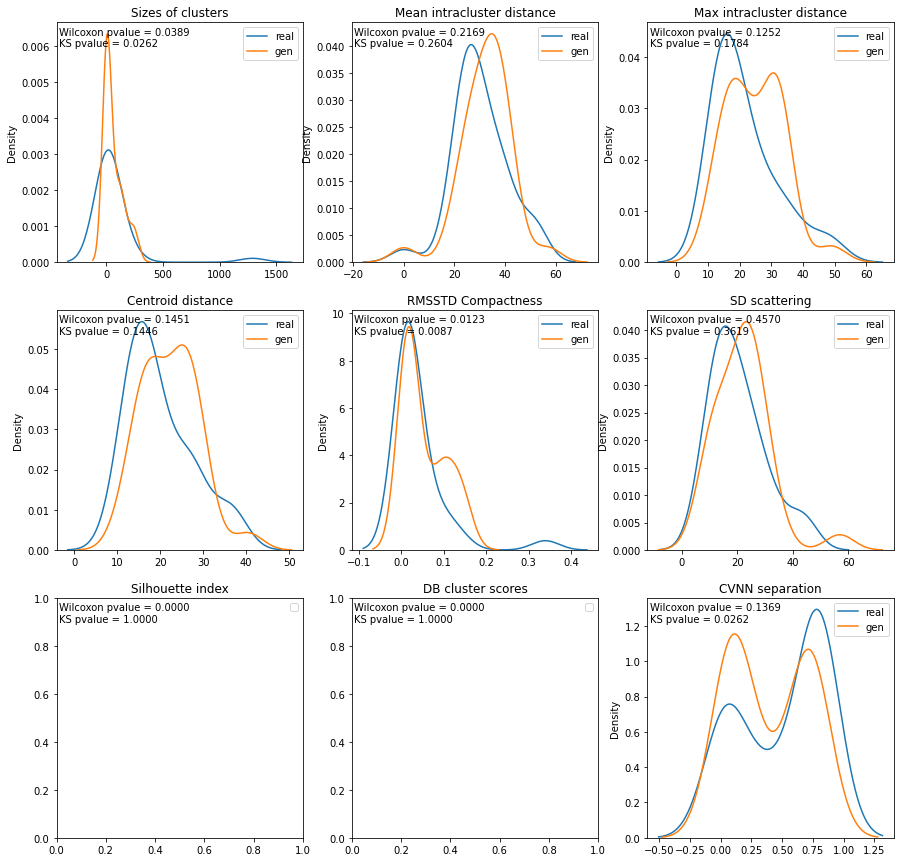

In [ ]:
mc1 = Counter(labels).most_common(1)[0][0]
mc2 = Counter(labels_g).most_common(1)[0][0]
not_noize = [label !=  mc1 for label in labels]
not_noize_g = [label != mc2 for label in labels_g]

f2, w, k = run_all_stat_tests(ngrams[:5000][not_noize], labels[not_noize], ngrams_g[:5000][not_noize_g], labels_g[not_noize_g])

(0, 13752)